
## Import necessary libraries

In [1]:
import torch

# Verifica si CUDA (GPU) está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [2]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
import time
import logging
import random
from collections import defaultdict, Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')


# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize, sent_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

# Import Pytorch modules
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.autograd import Variable
from torch.optim import Adam, AdamW

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luisl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\luisl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\luisl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification
import warnings
warnings.filterwarnings("ignore")

## cargar texto resumido 

In [4]:
import pickle

# Define the path to the pickle file (same as before)
ruta_pickle = 'C:/Users/luisl/OneDrive/Escritorio/TFM_IA3/tfm_ia3_nodata/data/preprocessed/text_resumido_v2_completo.pkl'

# Open the file in binary read mode
with open(ruta_pickle, 'rb') as pickle_file:
  # Use pickle.load to deserialize the data and create a new DataFrame
  loaded_df = pickle.load(pickle_file)

print("¡DataFrame cargado del archivo pickle exitosamente!")

¡DataFrame cargado del archivo pickle exitosamente!


In [5]:
loaded_df.head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,summary
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...,I think it's better to take them up later in t...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...,I am distressed about what happened after the ...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...,I thought we might change the order [of the ag...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro...",Everybody in this room has a significantly hig...
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ...",I don't know that we've been that precise abou...


In [6]:
train_sent_df = loaded_df

In [7]:
import pandas as pd

# Porcentaje deseado de las filas (e.g., 10%)
porcentaje = 100

# Calcula el número de filas a seleccionar basado en el porcentaje
num_filas = int(len(train_sent_df) * (porcentaje / 100))

# Selecciona aleatoriamente el porcentaje deseado de filas del DataFrame
submuestra_df = train_sent_df.sample(n=num_filas)

submuestra_df = submuestra_df.dropna(subset=['next_decision'])

# Convierte la columna deseada a una lista
X_submuestra = submuestra_df['summary'].to_list()



carga del primer modelo reentrenado

In [9]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Define labels
labels = ['negative', 'neutral', 'positive']

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')

# Define the path to the saved model
model_path = "C:/Users/luisl/OneDrive/Escritorio/TFM_IA3/tfm_ia3_nodata/models/best_model_5e-05_64_V2.pt"  # Replace with your actual path

# Function to preprocess text
def preprocess_text(text, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    input_ids = inputs.input_ids.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    attention_mask = inputs.attention_mask.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    return input_ids, attention_mask

# Load the model
model_finbert = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model_finbert.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
model_finbert.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # Move to GPU if available

model_finbert.eval()  # Set model to evaluation mode

# Example usage
text = "The stock market is booming!"
input_ids, attention_mask = preprocess_text(text, tokenizer)

with torch.no_grad():
    # Get predictions
    outputs = model_finbert(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()

    # Get the predicted sentiment
    predicted_sentiment = labels[predicted_label]

    print(f"Predicted sentiment for '{text}': {predicted_sentiment}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Predicted sentiment for 'The stock market is booming!': positive


twitter-roberta-base-sentiment Model¶


In [11]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
model_roberta = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model_path = "C:/Users/luisl/OneDrive/Escritorio/TFM_IA3/tfm_ia3_nodata/models/best_model_5e-05_64_V2.pt"  # Replace with your actual path
model_roberta.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))  # Load on CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_roberta.to(device)  # Move model to GPU if available

# Define tokenizer kwargs and labels
tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}
labels = ['negative', 'neutral', 'positive']

# Assuming X_submuestra is your list of texts to analyze
preds_roberta = []
preds_proba_roberta = []

for x in tqdm(X_submuestra, desc="Processing predictions"):
    with torch.no_grad():
        # Tokenize and move the input text to the GPU
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs).to(device)
        # Get the logits from the model
        logits = model_roberta(**input_sequence).logits
        # Apply softmax on the GPU
        scores = torch.softmax(logits, dim=1).cpu().numpy().squeeze()

    sentimiento_general = labels[np.argmax(scores)]
    probabilidad_general = np.max(scores)

    preds_roberta.append(sentimiento_general)
    preds_proba_roberta.append(probabilidad_general)


Processing predictions: 100%|██████████| 4597/4597 [07:12<00:00, 10.62it/s]


In [12]:
submuestra_df['predicted_roberta'] = preds_roberta; submuestra_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,summary,predicted_roberta
12117,speech,1998-04-02,Come with me to the FOMC,Governor Laurence H. Meyer,8725,<NA>,NaN,1998-05-19,0,5.5,"The title for my lecture today is ""Come with M...","""Come with Me to the FOMC"" is the title of the...",neutral
666,presconf_script,2012-12-12,FOMC Press Conference Transcript,Ben Bernanke,159,-1,0.0,2013-01-30,0,0.0,"Well, first of all, again, these--the projecti...",The projections that you're looking at are bas...,neutral
12265,speech,2000-08-31,Why risk management is important for global fi...,Governor Laurence H. Meyer,3951,<NA>,NaN,2000-10-03,0,6.5,I am very pleased to have been invited to addr...,Banks have been practicing risk management eve...,neutral
683,presconf_script,2012-12-12,FOMC Press Conference Transcript,STEVE BECKNER,93,-1,0.0,2013-01-30,0,0.0,"Mr. Chairman, Steve Beckner of Market News Int...","Mr. Chairman, Steve Beckner of Market News Int...",neutral
1994,presconf_script,2023-05-03,FOMC Press Conference Transcript,MICHELLE SMITH. Edward. EDWARD LAWRENCE,414,1,5.0,2023-06-14,0,5.0,"Thank you very much, Chair Powell. Edward Lawr...",Chair Powell: We're not looking to get to 3 pe...,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,presconf_script,2021-09-22,FOMC Press Conference Transcript,MICHELLE SMITH,827,0,0.0,2021-11-03,0,0.0,Great. Thank you. We'll go to Edward Lawrence....,Powell: Corporate defaults are very low in the...,neutral
548,presconf_script,2012-04-25,FOMC Press Conference Transcript,Ben Bernanke,891,0,0.0,2012-06-20,-1,0.0,"Good afternoon. Before we get to questions, I'...",Incoming information suggests that the economy...,neutral
13474,speech,2020-05-13,Current Economic Issues,Jerome Powell,1206,<NA>,NaN,2020-06-10,0,0.0,The coronavirus has left a devastating human a...,Fed Chairman Ben Bernanke: The scope and speed...,negative
14055,testimony,2011-02-17,Implementation of the Dodd-Frank Act,Ben Bernanke,1658,<NA>,NaN,2011-03-15,0,0.0,"Chairman Johnson, Ranking Member Shelby, and o...",The Federal Reserve is committed to working wi...,positive


In [13]:
submuestra_df.head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,summary,predicted_roberta
12117,speech,1998-04-02,Come with me to the FOMC,Governor Laurence H. Meyer,8725,<NA>,NaN,1998-05-19,0,5.5,"The title for my lecture today is ""Come with M...","""Come with Me to the FOMC"" is the title of the...",neutral
666,presconf_script,2012-12-12,FOMC Press Conference Transcript,Ben Bernanke,159,-1,0.0,2013-01-30,0,0.0,"Well, first of all, again, these--the projecti...",The projections that you're looking at are bas...,neutral
12265,speech,2000-08-31,Why risk management is important for global fi...,Governor Laurence H. Meyer,3951,<NA>,NaN,2000-10-03,0,6.5,I am very pleased to have been invited to addr...,Banks have been practicing risk management eve...,neutral
683,presconf_script,2012-12-12,FOMC Press Conference Transcript,STEVE BECKNER,93,-1,0.0,2013-01-30,0,0.0,"Mr. Chairman, Steve Beckner of Market News Int...","Mr. Chairman, Steve Beckner of Market News Int...",neutral
1994,presconf_script,2023-05-03,FOMC Press Conference Transcript,MICHELLE SMITH. Edward. EDWARD LAWRENCE,414,1,5.0,2023-06-14,0,5.0,"Thank you very much, Chair Powell. Edward Lawr...",Chair Powell: We're not looking to get to 3 pe...,neutral


In [14]:
selected_columns_df = submuestra_df[['date', 'predicted_roberta', 'next_meeting','next_decision']]

In [15]:
# Define el diccionario de mapeo
mapping = {'negative': -1, 'positive': 1, 'neutral': 0}

# Reemplaza los valores en la columna 'predicted_roberta'
selected_columns_df['predicted_roberta'] = selected_columns_df['predicted_roberta'].replace(mapping)

In [16]:
selected_columns_df.head()

,date,predicted_roberta,next_meeting,next_decision
12117,1998-04-02,0,1998-05-19,0
666,2012-12-12,0,2013-01-30,0
12265,2000-08-31,0,2000-10-03,0
683,2012-12-12,0,2013-01-30,0
1994,2023-05-03,0,2023-06-14,0


Cargar datos numericos

In [17]:
# Load previously processed non-text data
# Load data
file = open('C:/Users/luisl/OneDrive/Escritorio/TFM_IA3/tfm_ia3_nodata/data/train_data/nontext_train_small.pickle', 'rb')
train_df = pickle.load(file)
file.close()

print(train_df.shape)
train_df

(403, 13)


,target,RateDiff,prev_decision,Employ_diff_year,Rsales_diff_year,Unemp_diff_year,Employ_diff_prev,GDP_diff_year,PCE_diff_prev,Unemp_diff_prev,Hsales_diff_year,GDP_diff_prev,Taylor
date,,,,,,,,,,,,,
1982-10-05,-1,-0.50,0,-2294.0,2.004317,-2.5,-180.0,-1.010745,0.460401,-0.3,42.307692,0.456177,11.061999
1982-11-16,-1,-0.50,-1,-2473.0,2.004317,-2.5,-276.0,-2.556042,0.370245,-0.3,34.831461,-0.382267,10.045779
1982-12-21,0,0.00,-1,-2385.0,2.004317,-2.5,-121.0,-2.556042,0.634292,-0.4,45.026178,-0.382267,10.105638
1983-01-14,0,0.00,0,-2124.0,2.004317,-2.3,-15.0,-2.556042,0.368789,0.0,14.004376,-0.382267,9.766001
1983-01-21,0,0.00,0,-2124.0,2.004317,-2.3,-15.0,-2.556042,0.368789,0.0,14.004376,-0.382267,9.766001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-14,0,0.00,1,3928.0,-1.938580,-0.1,281.0,1.717927,0.306901,-0.3,11.635220,0.556381,12.123858
2023-07-26,1,0.25,0,3663.0,-1.573436,0.0,105.0,1.717927,0.288262,0.1,21.314387,0.556381,12.011106
2023-09-20,0,0.00,1,3144.0,-0.840916,-0.1,165.0,2.382468,0.119978,-0.3,2.507837,0.511122,11.295164


In [18]:
train_df.reset_index(inplace=True)

In [19]:
train_df.columns

Index(['date', 'target', 'RateDiff', 'prev_decision', 'Employ_diff_year',
       'Rsales_diff_year', 'Unemp_diff_year', 'Employ_diff_prev',
       'GDP_diff_year', 'PCE_diff_prev', 'Unemp_diff_prev', 'Hsales_diff_year',
       'GDP_diff_prev', 'Taylor'],
      dtype='object')

unir los dos datasets, ponderando entre fechas el sentimientyo medio

In [20]:
df1= selected_columns_df
df2 = train_df

In [21]:
import pandas as pd
import numpy as np

# Crea una lista para almacenar los datos fusionados
merged_data = []

# Itera sobre cada fila de df1
for index, row in df1.iterrows():
    # Verifica si 'next_meeting' es un valor NaN o si no es del tipo datetime
    if pd.isnull(row['next_meeting']) or not isinstance(row['next_meeting'], pd.Timestamp):
        continue  # Salta esta fila si 'next_meeting' no es válido
    
    # Filtra df1 para las fechas en el rango definido por la fila actual de df1
    subset_df1 = df1[(df1['date'] >= row['date']) & (df1['date'] <= row['next_meeting'])]
    
    # Calcula el promedio de 'predicted_roberta' en el rango de fechas
    predicted_roberta_avg = subset_df1['predicted_roberta'].mean()
    
    # Añade los datos al resultado fusionado
    merged_data.append({
        'date': row['date'],
        'predicted_roberta': predicted_roberta_avg
    })

# Crea un DataFrame a partir de la lista de datos fusionados
merged_df = pd.DataFrame(merged_data)

# Fusiona 'merged_df' con 'df2' en la columna 'date'
merged_df = pd.merge(merged_df, df2, on='date', how='inner')

# Ordena el DataFrame por la columna 'date'
merged_df = merged_df.sort_values(by='date')




In [22]:

# Ordena el DataFrame por la columna 'date'
merged_df = merged_df.sort_values(by='date')

In [23]:
# Elimina las filas duplicadas del DataFrame
merged_df.drop_duplicates(inplace=True)

# Ordena el DataFrame por la columna 'date'
merged_df = merged_df.sort_values(by='date')


In [24]:
merged_df.head()

,date,predicted_roberta,target,RateDiff,prev_decision,Employ_diff_year,Rsales_diff_year,Unemp_diff_year,Employ_diff_prev,GDP_diff_year,PCE_diff_prev,Unemp_diff_prev,Hsales_diff_year,GDP_diff_prev,Taylor
1317,1982-10-05,-0.5,-1,-0.500,0,-2294.0,2.004317,-2.5,-180.0,-1.010745,0.460401,-0.3,42.307692,0.456177,11.061999
1114,1982-11-16,0.0,-1,-0.500,-1,-2473.0,2.004317,-2.5,-276.0,-2.556042,0.370245,-0.3,34.831461,-0.382267,10.045779
1963,1982-12-21,1.0,0,0.000,-1,-2385.0,2.004317,-2.5,-121.0,-2.556042,0.634292,-0.4,45.026178,-0.382267,10.105638
69,1983-02-09,0.0,0,0.000,0,-1575.0,2.004317,-1.8,219.0,-1.443184,0.318443,0.4,58.152174,0.040009,9.324123
356,1983-03-29,0.0,1,0.125,0,-1646.0,2.004317,-1.5,-73.0,-1.443184,0.683700,0.0,53.972603,0.040009,9.435454


In [ ]:
#merged_df.drop(columns=['level_0', 'index'], inplace=True)

In [25]:
# Realiza la fusión de los DataFrames por la columna 'date'
merged_df = pd.merge(merged_df, df1[['date', 'next_meeting', 'next_decision']], on='date', how='inner')

# Ordena el DataFrame por la columna 'date'
merged_df = merged_df.sort_values(by='date')

In [26]:
# Elimina las filas duplicadas del DataFrame
merged_df.drop_duplicates(inplace=True)

df unificado

In [27]:
merged_df.shape

(328, 17)

In [28]:
merged_df.drop(columns=['target', 'next_meeting'], inplace=True)

In [29]:
merged_df.tail()

,date,predicted_roberta,RateDiff,prev_decision,Employ_diff_year,Rsales_diff_year,Unemp_diff_year,Employ_diff_prev,GDP_diff_year,PCE_diff_prev,Unemp_diff_prev,Hsales_diff_year,GDP_diff_prev,Taylor,next_decision
2264,2023-05-03,0.105263,0.25,1,4048.0,-2.662041,0.1,217.0,1.717927,0.335926,0.1,-9.476662,0.556381,12.153794,0
2291,2023-06-14,0.087912,0.00,1,3928.0,-1.938580,-0.1,281.0,1.717927,0.306901,-0.3,11.635220,0.556381,12.123858,1
2339,2023-07-26,0.126437,0.25,0,3663.0,-1.573436,0.0,105.0,1.717927,0.288262,0.1,21.314387,0.556381,12.011106,0
2372,2023-09-20,0.084211,0.00,1,3144.0,-0.840916,-0.1,165.0,2.382468,0.119978,-0.3,2.507837,0.511122,11.295164,0
2411,2023-11-01,0.022727,0.00,0,3056.0,0.295139,-0.3,262.0,2.926887,0.329011,0.0,23.456790,1.193871,10.970821,0


In [30]:
import pandas as pd

# Assuming your DataFrame is named 'df'

# Replace 'data.csv' with the desired filename
csv_filename = 'entrenamiento.csv'

# Save DataFrame to CSV in the current directory
merged_df.to_csv(csv_filename, index=False)

print(f"DataFrame saved as '{csv_filename}' in the current directory.")


DataFrame saved as 'entrenamiento.csv' in the current directory.


In [72]:
import pandas as pd

# Assuming the CSV file is named 'data.csv'

# Replace 'data.csv' with the filename of your CSV file
csv_filename = 'entrenamiento.csv'

# Load CSV file into a DataFrame
merged_df = pd.read_csv(csv_filename)

print("DataFrame loaded successfully.")


DataFrame loaded successfully.


In [43]:
merged_df.head()

,date,predicted_roberta,RateDiff,prev_decision,Employ_diff_year,Rsales_diff_year,Unemp_diff_year,Employ_diff_prev,GDP_diff_year,PCE_diff_prev,Unemp_diff_prev,Hsales_diff_year,GDP_diff_prev,Taylor,next_decision
0,1982-10-05,-0.5,-0.500,0,-2294.0,2.004317,-2.5,-180.0,-1.010745,0.460401,-0.3,42.307692,0.456177,11.061999,-1
1,1982-11-16,0.0,-0.500,-1,-2473.0,2.004317,-2.5,-276.0,-2.556042,0.370245,-0.3,34.831461,-0.382267,10.045779,0
2,1982-12-21,1.0,0.000,-1,-2385.0,2.004317,-2.5,-121.0,-2.556042,0.634292,-0.4,45.026178,-0.382267,10.105638,0
3,1983-02-09,0.0,0.000,0,-1575.0,2.004317,-1.8,219.0,-1.443184,0.318443,0.4,58.152174,0.040009,9.324123,1
4,1983-03-29,0.0,0.125,0,-1646.0,2.004317,-1.5,-73.0,-1.443184,0.683700,0.0,53.972603,0.040009,9.435454,0


## ENTRENAMIENTO DE MODELOS

### SEQUENTIAL

In [ ]:
df = merged_df

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3342 - loss: 4.7889 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3151 - loss: 10.0447
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6847 - loss: 2.4283 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6847 - loss: 2.9977 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3845 - loss: 1.8747 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6847 - loss: 0.9647 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6847 - loss: 1.0494 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6847 - loss: 1.4033 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6847 - loss: 0.8477 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6847 - loss: 0.9502 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7040 - loss: 9.5401 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3151 - loss: 11.5235
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2921 - loss: 7.3040 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6654 - loss: 

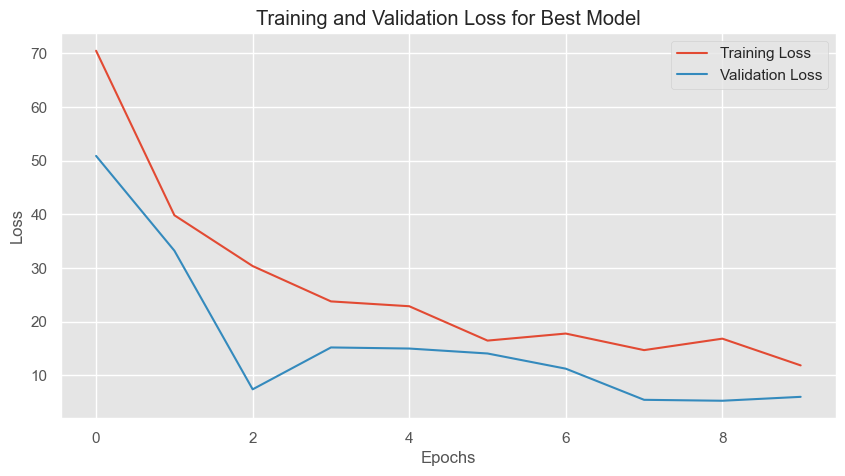

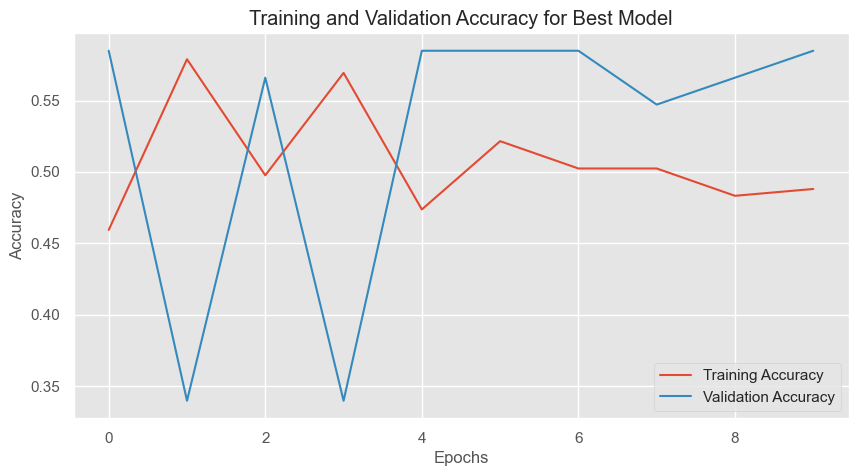

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6847 - loss: 5.4110 
Test Accuracy of the Best Model: 0.6818181872367859


In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Data Preprocessing
# Assuming merged_df is your DataFrame containing the data
# One-hot encode the categorical column prev_decision
df = pd.get_dummies(df, columns=['prev_decision'])

# Separate features (X) and target variable (y)
X = df.drop(['next_decision', 'date'], axis=1)
y = df['next_decision']

# Convert y to one-hot encoding
y = tf.keras.utils.to_categorical(y, num_classes=3)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameters to test
batch_sizes = [8, 16, 32, 64]
learning_rates = [0.001, 0.01]
num_epochs = [10, 15, 25, 35, 50]

best_accuracy = 0
best_hyperparameters = None

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        for epochs in num_epochs:
            # Step 2: Define Model Architecture
            model = Sequential([
                Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
                Dropout(0.2),  # Adding dropout for regularization
                Dense(64, activation='relu'),
                Dropout(0.2),
                Dense(32, activation='relu'),
                Dense(3, activation='softmax')  # Output layer with softmax activation for multi-class classification
            ])

            # Step 3: Compile the Model
            optimizer = Adam(learning_rate=learning_rate)  # Adjusting learning rate
            model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

            # Step 4: Training
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)

            # Step 5: Evaluation
            loss, accuracy = model.evaluate(X_test, y_test)
            
            # Update best accuracy and hyperparameters if current accuracy is better
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_hyperparameters = (batch_size, learning_rate, epochs)
            
            # Store training and validation loss and accuracy
            train_losses.append(history.history['loss'])
            val_losses.append(history.history['val_loss'])
            train_accuracies.append(history.history['accuracy'])
            val_accuracies.append(history.history['val_accuracy'])

# Initialize lists to store loss and accuracy for the best model
best_train_loss = []
best_val_loss = []
best_train_accuracy = []
best_val_accuracy = []

# Train the best model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])
optimizer = Adam(learning_rate=best_hyperparameters[1])
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=best_hyperparameters[2], batch_size=best_hyperparameters[0], validation_split=0.2, verbose=0)

# Evaluate the best model on test data
best_train_loss = history.history['loss']
best_val_loss = history.history['val_loss']
best_train_accuracy = history.history['accuracy']
best_val_accuracy = history.history['val_accuracy']

# Plotting training and validation loss for the best model
plt.figure(figsize=(10, 5))
plt.plot(best_train_loss, label='Training Loss')
plt.plot(best_val_loss, label='Validation Loss')
plt.title('Training and Validation Loss for Best Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy for the best model
plt.figure(figsize=(10, 5))
plt.plot(best_train_accuracy, label='Training Accuracy')
plt.plot(best_val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy for Best Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the best model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Print the test accuracy of the best model
print(f"Test Accuracy of the Best Model: {test_accuracy}")

### LSTM

In [78]:
df = merged_df

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7040 - loss: 0.9718 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6847 - loss: 0.9678 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7040 - loss: 1.0246 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6847 - loss: 1.1442 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6847 - loss: 1.0079 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6847 - loss: 1.0614 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6847 - loss: 1.1030 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7040 - loss: 1.0751 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7040 - loss: 1.0994 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6847 - loss: 1.3316 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7040 - loss: 0.9030 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6847 - loss: 0.9952 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6847 - loss: 0.9968 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6847 - loss: 

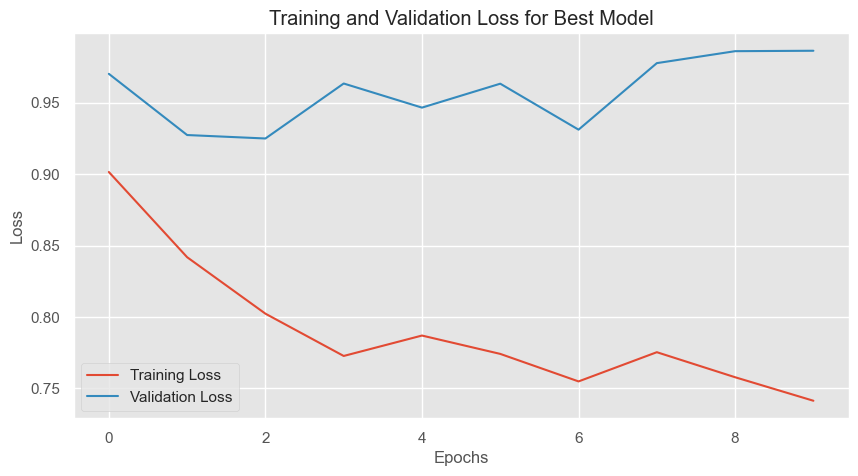

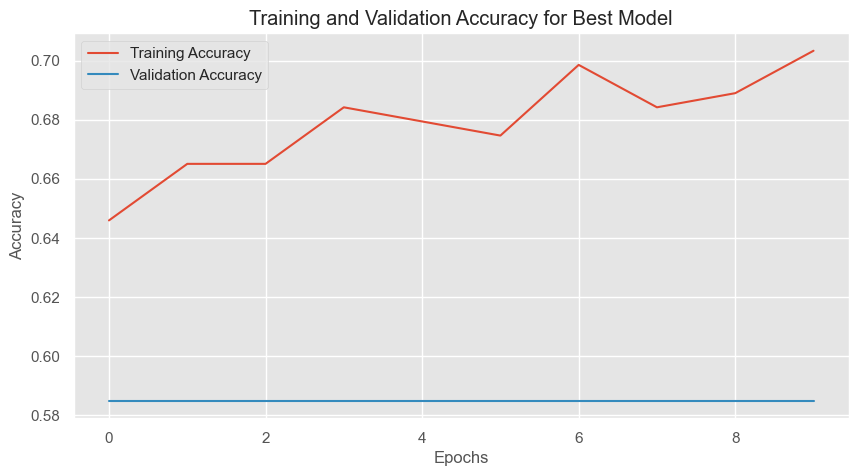

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6847 - loss: 0.9740 
Test Accuracy of the Best Model: 0.6818181872367859
Best Hyperparameters: Batch Size - 8, Learning Rate - 0.001, Epochs - 10


In [79]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Data Preprocessing
# Assuming merged_df is your DataFrame containing the data
# One-hot encode the categorical column prev_decision
df = pd.get_dummies(df, columns=['prev_decision'])

# Separate features (X) and target variable (y)
X = df.drop(['next_decision', 'date'], axis=1)
y = df['next_decision']

# Convert y to one-hot encoding
y = tf.keras.utils.to_categorical(y, num_classes=3)

# Reshape X to 3D array (samples, timesteps, features)
X = X.to_numpy().reshape(X.shape[0], 1, X.shape[1])

# Convert X_train and X_test to the appropriate data type
X = X.astype('float32')

# Convert y to the appropriate data type
y = y.astype('int32')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameters to test
batch_sizes = [8, 16, 32, 64]
learning_rates = [0.001, 0.01]
num_epochs = [10, 15, 25, 35, 50]

best_accuracy = 0
best_hyperparameters = None

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        for epochs in num_epochs:
            # Step 2: Define Model Architecture
            model = Sequential([
                LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])),
                Dropout(0.2),  # Adding dropout for regularization
                Dense(64, activation='relu'),
                Dropout(0.2),
                Dense(32, activation='relu'),
                Dense(3, activation='softmax')  # Output layer with softmax activation for multi-class classification
            ])

            # Step 3: Compile the Model
            optimizer = Adam(learning_rate=learning_rate)  # Adjusting learning rate
            model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

            # Step 4: Training
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)

            # Step 5: Evaluation
            loss, accuracy = model.evaluate(X_test, y_test)
            
            # Update best accuracy and hyperparameters if current accuracy is better
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_hyperparameters = (batch_size, learning_rate, epochs)
            
            # Store training and validation loss and accuracy
            train_losses.append(history.history['loss'])
            val_losses.append(history.history['val_loss'])
            train_accuracies.append(history.history['accuracy'])
            val_accuracies.append(history.history['val_accuracy'])

# Initialize lists to store loss and accuracy for the best model
best_train_loss = []
best_val_loss = []
best_train_accuracy = []
best_val_accuracy = []

# Train the best model
model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])
optimizer = Adam(learning_rate=best_hyperparameters[1])
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=best_hyperparameters[2], batch_size=best_hyperparameters[0], validation_split=0.2, verbose=0)

# Evaluate the best model on test data
best_train_loss = history.history['loss']
best_val_loss = history.history['val_loss']
best_train_accuracy = history.history['accuracy']
best_val_accuracy = history.history['val_accuracy']

# Plotting training and validation loss for the best model
plt.figure(figsize=(10, 5))
plt.plot(best_train_loss, label='Training Loss')
plt.plot(best_val_loss, label='Validation Loss')
plt.title('Training and Validation Loss for Best Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy for the best model
plt.figure(figsize=(10, 5))
plt.plot(best_train_accuracy, label='Training Accuracy')
plt.plot(best_val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy for Best Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the best model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Print the test accuracy of the best model
print(f"Test Accuracy of the Best Model: {test_accuracy}")
print(f"Best Hyperparameters: Batch Size - {best_hyperparameters[0]}, Learning Rate - {best_hyperparameters[1]}, Epochs - {best_hyperparameters[2]}")


### CNN

In [98]:
df = merged_df

In [99]:
df.head()

,date,predicted_roberta,RateDiff,prev_decision,Employ_diff_year,Rsales_diff_year,Unemp_diff_year,Employ_diff_prev,GDP_diff_year,PCE_diff_prev,Unemp_diff_prev,Hsales_diff_year,GDP_diff_prev,Taylor,next_decision
0,1982-10-05,-0.5,-0.500,0,-2294.0,2.004317,-2.5,-180.0,-1.010745,0.460401,-0.3,42.307692,0.456177,11.061999,-1
1,1982-11-16,0.0,-0.500,-1,-2473.0,2.004317,-2.5,-276.0,-2.556042,0.370245,-0.3,34.831461,-0.382267,10.045779,0
2,1982-12-21,1.0,0.000,-1,-2385.0,2.004317,-2.5,-121.0,-2.556042,0.634292,-0.4,45.026178,-0.382267,10.105638,0
3,1983-02-09,0.0,0.000,0,-1575.0,2.004317,-1.8,219.0,-1.443184,0.318443,0.4,58.152174,0.040009,9.324123,1
4,1983-03-29,0.0,0.125,0,-1646.0,2.004317,-1.5,-73.0,-1.443184,0.683700,0.0,53.972603,0.040009,9.435454,0


In [100]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# Assuming merged_df is your DataFrame containing the data
# One-hot encode the categorical column prev_decision
df = pd.get_dummies(df, columns=['prev_decision'])

# Separate features (X) and target variable (y)
X = df.drop(['next_decision', 'date'], axis=1)
y = df['next_decision']

# Convert y to one-hot encoding
y = tf.keras.utils.to_categorical(y, num_classes=3)

# Reshape X to 3D array (samples, timesteps, features)
X = X.to_numpy().reshape(X.shape[0], 1, X.shape[1])

# Convert X_train and X_test to the appropriate data type
X = X.astype('float32')

# Convert y to the appropriate data type
y = y.astype('int32')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameters to test
batch_sizes = [8, 16, 32, 64]
learning_rates = [0.001, 0.01]
num_epochs = [10, 15, 25, 35, 50]

best_accuracy = 0
best_hyperparameters = None

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        for epochs in num_epochs:
            # Define Model Architecture
            model = Sequential([
                Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
                MaxPooling1D(pool_size=2),
                Conv1D(32, kernel_size=3, activation='relu'),
                MaxPooling1D(pool_size=2),
                Flatten(),
                Dense(128, activation='relu'),
                Dropout(0.5),
                Dense(3, activation='softmax')
            ])

            # Compile the Model
            optimizer = Adam(learning_rate=learning_rate)
            model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

            # Training
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)

            # Evaluation
            loss, accuracy = model.evaluate(X_test, y_test)
            
            # Update best accuracy and hyperparameters if current accuracy is better
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_hyperparameters = (batch_size, learning_rate, epochs)
            
            # Store training and validation loss and accuracy
            train_losses.append(history.history['loss'])
            val_losses.append(history.history['val_loss'])
            train_accuracies.append(history.history['accuracy'])
            val_accuracies.append(history.history['val_accuracy'])

# Initialize lists to store loss and accuracy for the best model
best_train_loss = []
best_val_loss = []
best_train_accuracy = []
best_val_accuracy = []

# Train the best model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
optimizer = Adam(learning_rate=best_hyperparameters[1])
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=best_hyperparameters[2], batch_size=best_hyperparameters[0], validation_split=0.2, verbose=0)

# Evaluate the best model on test data
best_train_loss = history.history['loss']
best_val_loss = history.history['val_loss']
best_train_accuracy = history.history['accuracy']
best_val_accuracy = history.history['val_accuracy']

# Plotting training and validation loss for the best model
plt.figure(figsize=(10, 5))
plt.plot(best_train_loss, label='Training Loss')
plt.plot(best_val_loss, label='Validation Loss')
plt.title('Training and Validation Loss for Best Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy for the best model
plt.figure(figsize=(10, 5))
plt.plot(best_train_accuracy, label='Training Accuracy')
plt.plot(best_val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy for Best Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the best model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Print the test accuracy of the best model
print(f"Test Accuracy of the Best Model: {test_accuracy}")
print(f"Best Hyperparameters: Batch Size - {best_hyperparameters[0]}, Learning Rate - {best_hyperparameters[1]}, Epochs - {best_hyperparameters[2]}")


ValueError: Computed output size would be negative. Received `inputs shape=(None, 1, 15)`, `kernel shape=(3, 15, 64)`, `dilation_rate=[1]`.

### AUTOGLUON

In [73]:
df = merged_df

In [74]:
df.head()

,date,predicted_roberta,RateDiff,prev_decision,Employ_diff_year,Rsales_diff_year,Unemp_diff_year,Employ_diff_prev,GDP_diff_year,PCE_diff_prev,Unemp_diff_prev,Hsales_diff_year,GDP_diff_prev,Taylor,next_decision
0,1982-10-05,-0.5,-0.500,0,-2294.0,2.004317,-2.5,-180.0,-1.010745,0.460401,-0.3,42.307692,0.456177,11.061999,-1
1,1982-11-16,0.0,-0.500,-1,-2473.0,2.004317,-2.5,-276.0,-2.556042,0.370245,-0.3,34.831461,-0.382267,10.045779,0
2,1982-12-21,1.0,0.000,-1,-2385.0,2.004317,-2.5,-121.0,-2.556042,0.634292,-0.4,45.026178,-0.382267,10.105638,0
3,1983-02-09,0.0,0.000,0,-1575.0,2.004317,-1.8,219.0,-1.443184,0.318443,0.4,58.152174,0.040009,9.324123,1
4,1983-03-29,0.0,0.125,0,-1646.0,2.004317,-1.5,-73.0,-1.443184,0.683700,0.0,53.972603,0.040009,9.435454,0


In [75]:
df.drop('date', axis=1, inplace=True)

In [66]:

#columns_to_encode = ["prev_decision"]

# Convert the column to categorical type
#df["prev_decision"] = df["prev_decision"].astype("category")

# One-hot encode the specified column
#df = pd.get_dummies(df, columns=columns_to_encode, prefix="prev_decision")


'\ncolumns_to_encode = ["prev_decision"]\n\n# Convert the column to categorical type\ndf["prev_decision"] = df["prev_decision"].astype("category")\n\n# One-hot encode the specified column\ndf = pd.get_dummies(df, columns=columns_to_encode, prefix="prev_decision")\n'

In [76]:
df.head()

,predicted_roberta,RateDiff,prev_decision,Employ_diff_year,Rsales_diff_year,Unemp_diff_year,Employ_diff_prev,GDP_diff_year,PCE_diff_prev,Unemp_diff_prev,Hsales_diff_year,GDP_diff_prev,Taylor,next_decision
0,-0.5,-0.500,0,-2294.0,2.004317,-2.5,-180.0,-1.010745,0.460401,-0.3,42.307692,0.456177,11.061999,-1
1,0.0,-0.500,-1,-2473.0,2.004317,-2.5,-276.0,-2.556042,0.370245,-0.3,34.831461,-0.382267,10.045779,0
2,1.0,0.000,-1,-2385.0,2.004317,-2.5,-121.0,-2.556042,0.634292,-0.4,45.026178,-0.382267,10.105638,0
3,0.0,0.000,0,-1575.0,2.004317,-1.8,219.0,-1.443184,0.318443,0.4,58.152174,0.040009,9.324123,1
4,0.0,0.125,0,-1646.0,2.004317,-1.5,-73.0,-1.443184,0.683700,0.0,53.972603,0.040009,9.435454,0


In [77]:
print(df.shape)

(328, 14)


In [78]:
train_data = df.iloc[:300]
#subsample_size = 500  # subsample subset of data for faster demo, try setting this to much larger values
#train_data = train_data.sample(n=subsample_size, random_state=0)
train_data.head()

,predicted_roberta,RateDiff,prev_decision,Employ_diff_year,Rsales_diff_year,Unemp_diff_year,Employ_diff_prev,GDP_diff_year,PCE_diff_prev,Unemp_diff_prev,Hsales_diff_year,GDP_diff_prev,Taylor,next_decision
0,-0.5,-0.500,0,-2294.0,2.004317,-2.5,-180.0,-1.010745,0.460401,-0.3,42.307692,0.456177,11.061999,-1
1,0.0,-0.500,-1,-2473.0,2.004317,-2.5,-276.0,-2.556042,0.370245,-0.3,34.831461,-0.382267,10.045779,0
2,1.0,0.000,-1,-2385.0,2.004317,-2.5,-121.0,-2.556042,0.634292,-0.4,45.026178,-0.382267,10.105638,0
3,0.0,0.000,0,-1575.0,2.004317,-1.8,219.0,-1.443184,0.318443,0.4,58.152174,0.040009,9.324123,1
4,0.0,0.125,0,-1646.0,2.004317,-1.5,-73.0,-1.443184,0.683700,0.0,53.972603,0.040009,9.435454,0


In [79]:
print(train_data.shape)

(300, 14)


In [80]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [81]:
label = 'next_decision'
print(f"Unique classes: {list(train_data[label].unique())}")

Unique classes: [-1, 0, 1]


In [88]:
time_limit = 1000  # for quick demonstration only, you should set this to longest time you are willing to wait (in seconds)
metric = 'roc_auc'  # specify your evaluation metric here
predictor = TabularPredictor(label, eval_metric=metric).fit(train_data, time_limit=time_limit, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels\ag-20240428_114650"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 1000 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels\ag-20240428_114650\ds_sub_fit\sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.


In [ ]:
test_data =df.iloc[-5:]

In [ ]:
predictor.evaluate(test_data)

{'accuracy': 0.8, 'balanced_accuracy': 0.5000000000000006, 'mcc': 0.0}

In [ ]:
predictor.leaderboard(test_data)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,CatBoost,0.8,0.750000,accuracy,0.004003,0.002102,16.214873,0.004003,0.002102,16.214873,1,True,8
1,LightGBM,0.8,0.766667,accuracy,0.004995,0.007993,0.669987,0.004995,0.007993,0.669987,1,True,5
2,LightGBMLarge,0.8,0.683333,accuracy,0.004999,0.008110,1.694329,0.004999,0.008110,1.694329,1,True,13
3,WeightedEnsemble_L2,0.8,0.766667,accuracy,0.007995,0.008989,0.885748,0.003000,0.000996,0.215761,2,True,14
4,LightGBMXT,0.8,0.716667,accuracy,0.008008,0.007986,1.960550,0.008008,0.007986,1.960550,1,True,4
5,NeuralNetFastAI,0.8,0.683333,accuracy,0.017963,0.011999,3.575286,0.017963,0.011999,3.575286,1,True,3
6,NeuralNetTorch,0.8,0.750000,accuracy,0.019001,0.008010,1.233297,0.019001,0.008010,1.233297,1,True,12
7,KNeighborsDist,0.8,0.616667,accuracy,0.030447,0.034003,0.009001,0.030447,0.034003,0.009001,1,True,2
8,KNeighborsUnif,0.8,0.600000,accuracy,0.032961,0.041993,0.016075,0.032961,0.041993,0.016075,1,True,1
9,XGBoost,0.8,0.650000,accuracy,0.053641,0.005125,0.702397,0.053641,0.005125,0.702397,1,True,11


In [ ]:
print("AutoGluon infers problem type is: ", predictor.problem_type)
print("AutoGluon identified the following types of features:")
print(predictor.feature_metadata)

AutoGluon infers problem type is:  multiclass
AutoGluon identified the following types of features:
('float', []) : 12 | ['predicted_roberta', 'RateDiff', 'Employ_diff_year', 'Rsales_diff_year', 'Unemp_diff_year', ...]
('int', [])   :  1 | ['prev_decision']


In [ ]:
predictor.feature_importance(test_data)

Computing feature importance via permutation shuffling for 13 features using 5 rows with 5 shuffle sets...
	0.76s	= Expected runtime (0.15s per shuffle set)
	0.21s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
predicted_roberta,0.0,0.0,0.5,5,0.0,0.0
RateDiff,0.0,0.0,0.5,5,0.0,0.0
prev_decision,0.0,0.0,0.5,5,0.0,0.0
Employ_diff_year,0.0,0.0,0.5,5,0.0,0.0
Rsales_diff_year,0.0,0.0,0.5,5,0.0,0.0
Unemp_diff_year,0.0,0.0,0.5,5,0.0,0.0
Employ_diff_prev,0.0,0.0,0.5,5,0.0,0.0
GDP_diff_year,0.0,0.0,0.5,5,0.0,0.0
PCE_diff_prev,0.0,0.0,0.5,5,0.0,0.0
Unemp_diff_prev,0.0,0.0,0.5,5,0.0,0.0
